## Подключение к базе. Загрузка таблиц sql

In [2]:
pip install shap

     |████████████████████████████████| 572 kB 2.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns
import itertools

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn. metrics import precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

import catboost
from catboost import cv
from catboost import CatBoostClassifier
from xgboost import XGBRegressor

import shap

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore")

In [4]:
def integering(df,column):
    df[column] = df[column].astype(int)

In [5]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [6]:
engine = create_engine(connection_string) 

## Проведение первичного исследование таблиц

In [7]:
from IPython.display import display

In [8]:
query = '''
SELECT table_name
FROM information_schema.tables
'''

info_schema = pd.read_sql_query(query, con=engine)
display(info_schema)

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles
4,pg_foreign_table
...,...
171,foreign_data_wrappers
172,foreign_server_options
173,foreign_servers
174,foreign_table_options


In [9]:
query = '''
SELECT *
FROM collisions
'''
collision = pd.read_sql_query(query, con=engine)
display(collision.head())

del collision

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [10]:

query = '''
SELECT *
FROM vehicles
'''
vehicles = pd.read_sql_query(query, con=engine)
display(vehicles.head())

del vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


In [11]:
query = '''
SELECT *
FROM parties
'''
parties = pd.read_sql_query(query, con=engine)
display(parties.head())

del parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


Исходя из первичного осмотра базы данных, мы видим что все таблицы и столбцы в них присутствуют. Общий ключ case id присутствует.

##  Проведение статистического анализа факторов ДТП

#### Выяснение в какие месяцы происходит большиинство аварий

In [12]:
query = '''
SELECT COUNT(case_id), EXTRACT(MONTH FROM collision_date) as date
FROM collisions
GROUP BY date
ORDER BY date
'''
collision_2 = pd.read_sql_query(query, con=engine)

In [13]:
collision_2

,count,date
0,132044,1.0
1,128858,2.0
2,139581,3.0
3,130180,4.0
4,130316,5.0
5,102594,6.0
6,102227,7.0
7,104089,8.0
8,105159,9.0
9,112237,10.0


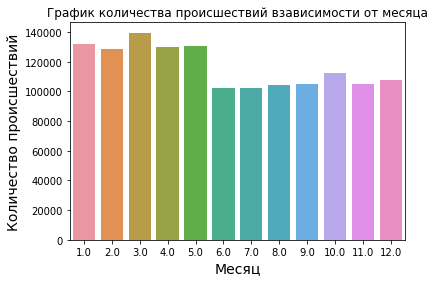

In [14]:
sns_plot = sns.barplot(data=collision_2, x="date", y="count")
sns_plot.set_title(f'График количества происшествий взависимости от месяца')
sns_plot.set_xlabel("Месяц", fontsize=14)
sns_plot.set_ylabel("Количество происшествий", fontsize=14)
plt.show()

Исходя из таблицы и графика мы можем увидеть, что наибольшее количество аварий происходит в первые 5 месяцев (возможно это связано с погодными условиями), достигая своего пика в марте (139581 происшествий), меньше всего аварий наблюдается летом, достигая минимума в июле (102227 происшествий)

In [15]:
query = '''
SELECT COUNT(case_id), EXTRACT(YEAR FROM collision_date) as year, EXTRACT(MONTH FROM collision_date) as month
FROM collisions
GROUP BY year,month
ORDER BY year,month
'''
collision_3 = pd.read_sql_query(query, con=engine)

In [16]:
collision_3

,count,year,month
0,35062,2009.0,1.0
1,34480,2009.0,2.0
2,36648,2009.0,3.0
3,35239,2009.0,4.0
4,36916,2009.0,5.0
5,34202,2009.0,6.0
6,35161,2009.0,7.0
7,34508,2009.0,8.0
8,35555,2009.0,9.0
9,37835,2009.0,10.0


Исходя из таблицы можем заметить, что очень мало данных имеется после 2012 года, поэтому графики по годам построим с 2009 по 2012 года включительно

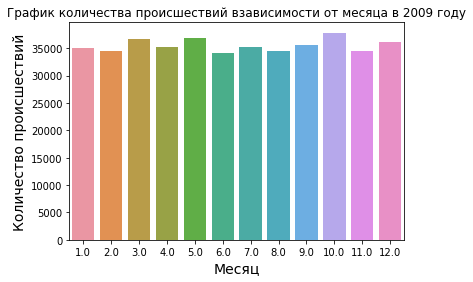

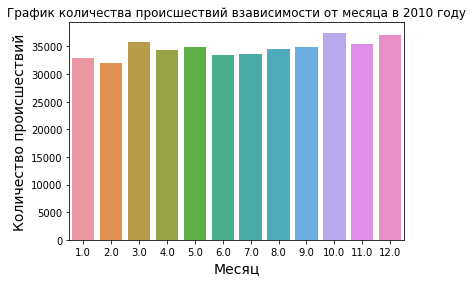

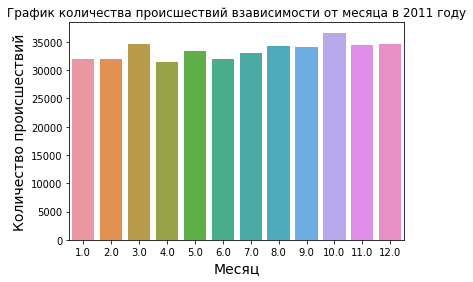

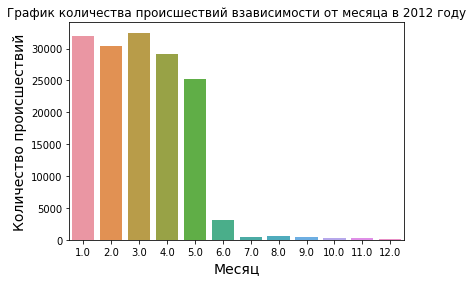

In [17]:
for i in range (2009,2013):
    df_coll = collision_3.query(f'year=={i}')
    sns_plot = sns.barplot(data=df_coll, x="month", y="count")
    sns_plot.set_title(f'График количества происшествий взависимости от месяца в {i} году')
    sns_plot.set_xlabel("Месяц", fontsize=14)
    sns_plot.set_ylabel("Количество происшествий", fontsize=14)
    plt.show()

Мы можем видеть, что если рассматривать данные отдельно по годам, то не существует значимых различий между месяцами, а в общей статистике более низкое количество ДТП после мая обуславливается тем, что нормальное заполнение (количество) данных присутствует лишь до июня 2012 года

#### Задачи коллегам

<b>1.</b> Связать количество дтп с возрастом автомобиля 
- Использовать базы данных с описанием автомобилей (Vehicles) и информацию о происшествиях (collisions). 
- Построить графики
- Сделать выводы

<b>2.</b> Проверить наличие связи состояния участника с количеством дтп
- Использовать таблицы базы данных с информацией о происшествиях (collisions) и таблицу с описанием участников (parties) 
- Построить графики и посмотреть в каком состоянии было больше всего аварий
- Сделать выводы

<b>3.</b> Првоерить наличие взаимосвязи между погодными условиями и количеством ДТП

<b>4.</b> Посмотреть какие основные факторы аварии повлияли на большинство аварий

<b>5.</b> Проверить наличие взаимосвязи состояния дороги с количеством ДТП

<b>6.</b> Проверить наличие взаимосвязи освещенности с количеством ДТП


## Создание модели для оценки водительского риска

In [18]:
query = '''
WITH table_1 as (
SELECT *,EXTRACT(MONTH FROM collision_date) as month
FROM collisions
WHERE (EXTRACT(YEAR FROM collision_date) =2012) AND (collision_damage NOT LIKE 'scratch')
ORDER BY case_id),

table_2 as (
SELECT * 
FROM parties 
WHERE (party_type LIKE 'car')),

table_3 as (
SELECT * 
FROM table_2 as t2
JOIN table_1 as t1 ON t1.case_id=t2.case_id
JOIN vehicles as v ON v.case_id=t2.case_id)


SELECT *
FROM table_3 as t3


'''
df = pd.read_sql_query(query, con=engine)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           118411 non-null  int64  
 1   case_id                      118411 non-null  object 
 2   party_number                 118411 non-null  int64  
 3   party_type                   118411 non-null  object 
 4   at_fault                     118411 non-null  int64  
 5   insurance_premium            113289 non-null  float64
 6   party_sobriety               116682 non-null  object 
 7   party_drug_physical          8695 non-null    object 
 8   cellphone_in_use             107507 non-null  float64
 9   case_id                      118411 non-null  object 
 10  county_city_location         118411 non-null  object 
 11  county_location              118411 non-null  object 
 12  distance                     118411 non-null  float64
 13 

In [19]:
df_2 = df[[
    #Таблица Parties
    'party_drug_physical', #Состояние участника: физическое или с учетом принятых лекарств
    'county_city_location',
    'primary_collision_factor',
    'collision_damage',
    'pcf_violation_category',
    'type_of_collision',
    'control_device',
    'party_type',
    'motor_vehicle_involved_with',
    'party_sobriety', #Трезвость
    'cellphone_in_use', #Наличие телефона в автомобиле (громкая связь)
    #Таблица Collisions
    #'month', #Месяц происшествия
    'intersection', #Является ли место происшествия перекрестком
    'weather_1', #Погода
    'road_surface', #Состояние дороги
    'lighting', #Освещение
    #'direction', #Направление движения (возможно при определенном движении, например утром на восток может слепить глаза)
    'distance', #Расстояние от главной дороги (возможно при бОльших расстояниях водители чувствуют себя более раскованно, например так как на этих участках меньше камер)
    #'location_type', #Тип дороги
    'road_condition_1', #Состояние дороги
    #Таблица Vehicles
    'vehicle_type', #Тип кузова
    'vehicle_transmission',#Тип КПП
    'vehicle_age', #Возраст автомобиля
    
    'at_fault' #target

]]

df_2

,party_drug_physical,county_city_location,primary_collision_factor,collision_damage,pcf_violation_category,type_of_collision,control_device,party_type,motor_vehicle_involved_with,party_sobriety,...,intersection,weather_1,road_surface,lighting,distance,road_condition_1,vehicle_type,vehicle_transmission,vehicle_age,at_fault
0,None,3712,vehicle code violation,small damage,automobile right of way,broadside,none,car,other motor vehicle,had not been drinking,...,1.0,cloudy,dry,daylight,0.0,other,sedan,auto,2.0,0
1,None,3712,vehicle code violation,small damage,automobile right of way,broadside,none,car,other motor vehicle,had not been drinking,...,1.0,cloudy,dry,daylight,0.0,other,sedan,auto,2.0,1
2,None,3404,vehicle code violation,small damage,speeding,rear end,none,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,auto,5.0,1
3,None,3404,vehicle code violation,small damage,speeding,rear end,none,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,auto,5.0,0
4,None,3400,unknown,small damage,unknown,broadside,functioning,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,auto,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,None,0109,vehicle code violation,small damage,automobile right of way,broadside,functioning,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,auto,3.0,1
118407,None,0109,vehicle code violation,small damage,automobile right of way,broadside,functioning,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,auto,3.0,0
118408,None,0109,vehicle code violation,small damage,traffic signals and signs,broadside,functioning,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,auto,7.0,1
118409,None,0109,vehicle code violation,small damage,traffic signals and signs,broadside,functioning,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,auto,7.0,0


In [20]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   party_drug_physical          8695 non-null    object 
 1   county_city_location         118411 non-null  object 
 2   primary_collision_factor     118147 non-null  object 
 3   collision_damage             118411 non-null  object 
 4   pcf_violation_category       116686 non-null  object 
 5   type_of_collision            117771 non-null  object 
 6   control_device               117957 non-null  object 
 7   party_type                   118411 non-null  object 
 8   motor_vehicle_involved_with  118079 non-null  object 
 9   party_sobriety               116682 non-null  object 
 10  cellphone_in_use             107507 non-null  float64
 11  intersection                 118043 non-null  float64
 12  weather_1                    118022 non-null  object 
 13 

Можно увидеть, что в данных существуют пропуски почти во всех столбцах

In [21]:
df_2['party_drug_physical'] = df_2['party_drug_physical'].fillna('Not stated') #Заполнение пропущенных значений "Не указано"
df_2['party_sobriety'] = df_2['party_sobriety'].fillna('Not stated')
#df_2['direction'] = df_2['direction'].fillna('Not stated')
df_2['cellphone_in_use'] = df_2['cellphone_in_use'].fillna(0) #Заполнение самым популярным вариантом
#df_2['location_type'] = df_2['location_type'].fillna('Not stated')#Заполнение неопределенными для того чтобы не оптерять большое количество данных
df_2['vehicle_transmission'] = df_2['vehicle_transmission'].replace(['auto','manual'],[1,0])
df_dropped = df_2.dropna()
df_dropped

,party_drug_physical,county_city_location,primary_collision_factor,collision_damage,pcf_violation_category,type_of_collision,control_device,party_type,motor_vehicle_involved_with,party_sobriety,...,intersection,weather_1,road_surface,lighting,distance,road_condition_1,vehicle_type,vehicle_transmission,vehicle_age,at_fault
0,Not stated,3712,vehicle code violation,small damage,automobile right of way,broadside,none,car,other motor vehicle,had not been drinking,...,1.0,cloudy,dry,daylight,0.0,other,sedan,1.0,2.0,0
1,Not stated,3712,vehicle code violation,small damage,automobile right of way,broadside,none,car,other motor vehicle,had not been drinking,...,1.0,cloudy,dry,daylight,0.0,other,sedan,1.0,2.0,1
2,Not stated,3404,vehicle code violation,small damage,speeding,rear end,none,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,5.0,1
3,Not stated,3404,vehicle code violation,small damage,speeding,rear end,none,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,5.0,0
4,Not stated,3400,unknown,small damage,unknown,broadside,functioning,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,Not stated,0109,vehicle code violation,small damage,automobile right of way,broadside,functioning,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,3.0,1
118407,Not stated,0109,vehicle code violation,small damage,automobile right of way,broadside,functioning,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,3.0,0
118408,Not stated,0109,vehicle code violation,small damage,traffic signals and signs,broadside,functioning,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,7.0,1
118409,Not stated,0109,vehicle code violation,small damage,traffic signals and signs,broadside,functioning,car,other motor vehicle,had not been drinking,...,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,7.0,0


In [22]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109429 entries, 0 to 118410
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   party_drug_physical          109429 non-null  object 
 1   county_city_location         109429 non-null  object 
 2   primary_collision_factor     109429 non-null  object 
 3   collision_damage             109429 non-null  object 
 4   pcf_violation_category       109429 non-null  object 
 5   type_of_collision            109429 non-null  object 
 6   control_device               109429 non-null  object 
 7   party_type                   109429 non-null  object 
 8   motor_vehicle_involved_with  109429 non-null  object 
 9   party_sobriety               109429 non-null  object 
 10  cellphone_in_use             109429 non-null  float64
 11  intersection                 109429 non-null  float64
 12  weather_1                    109429 non-null  object 
 13 

In [23]:
df_dropped.describe()

,cellphone_in_use,intersection,distance,vehicle_transmission,vehicle_age,at_fault
count,109429.000000,109429.000000,1.094290e+05,109429.000000,109429.000000,109429.000000
mean,0.019401,0.227252,7.620494e+02,0.477113,4.906405,0.471347
std,0.137929,0.419059,7.170042e+03,0.499478,3.270605,0.499181
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,5.000000e+00,0.000000,3.000000,0.000000
50%,0.000000,0.000000,1.300000e+02,0.000000,4.000000,0.000000
75%,0.000000,0.000000,5.280000e+02,1.000000,7.000000,1.000000
max,1.000000,1.000000,1.584000e+06,1.000000,161.000000,1.000000


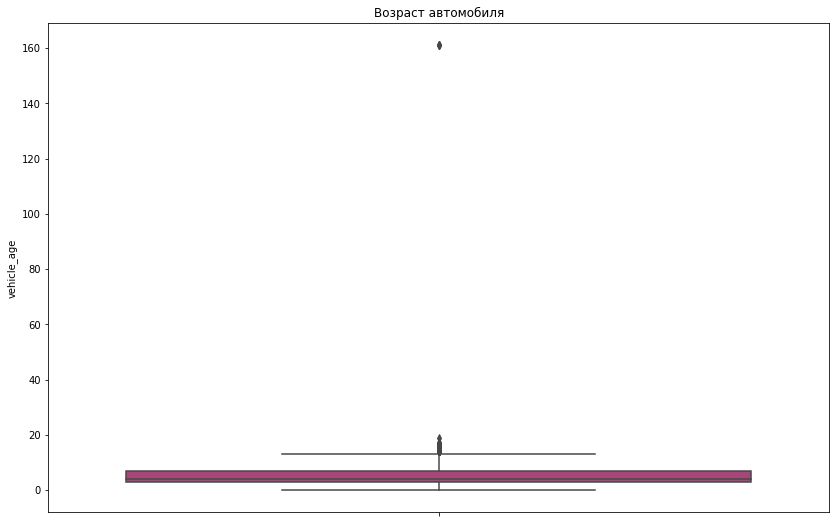

<AxesSubplot:xlabel='vehicle_age', ylabel='Count'>

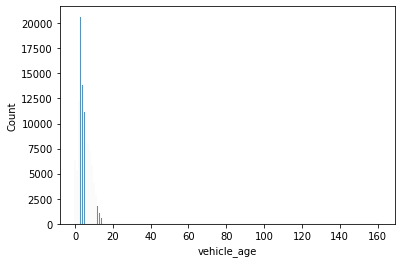

In [24]:
fig,ax = plt.subplots(figsize=(14,9))
sns.boxplot(y=df_dropped['vehicle_age'],palette='magma').set_title('Возраст автомобиля')
plt.show()
sns.histplot(df_dropped['vehicle_age'])

In [25]:
df_dropped.query('vehicle_age>30').count()

party_drug_physical            4
county_city_location           4
primary_collision_factor       4
collision_damage               4
pcf_violation_category         4
type_of_collision              4
control_device                 4
party_type                     4
motor_vehicle_involved_with    4
party_sobriety                 4
cellphone_in_use               4
intersection                   4
weather_1                      4
road_surface                   4
lighting                       4
distance                       4
road_condition_1               4
vehicle_type                   4
vehicle_transmission           4
vehicle_age                    4
at_fault                       4
dtype: int64

In [26]:
4/111885*100

0.003575099432452965

Исходя из данных и графика мы видим что существуют аномально высокие значение в более чем 100 лет, можно удалить их, плюс их и очень мало (4 штуки), что составляет всего 0.0036% данных


In [27]:
df_dropped = df_dropped.query('vehicle_age<30')

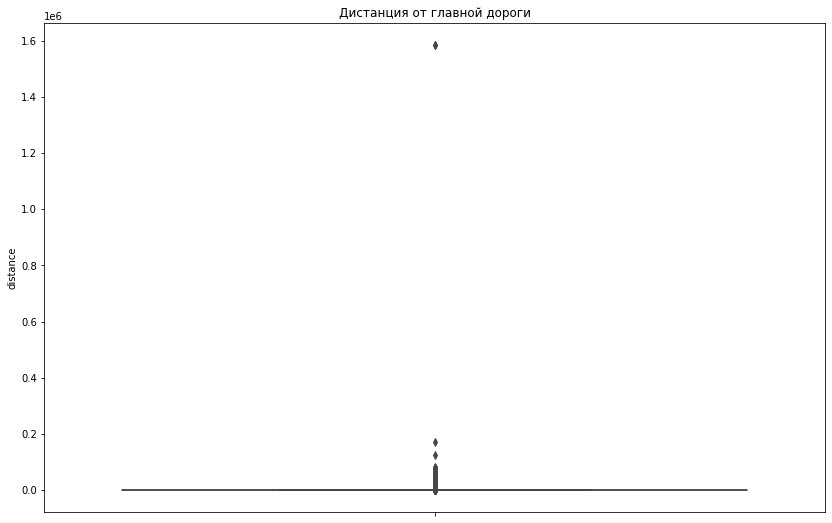

In [28]:
fig,ax = plt.subplots(figsize=(14,9))
sns.boxplot(y=df_dropped['distance'],palette='magma').set_title('Дистанция от главной дороги')
plt.show()

In [29]:
df_dropped.query('distance>2000').count()

party_drug_physical            9311
county_city_location           9311
primary_collision_factor       9311
collision_damage               9311
pcf_violation_category         9311
type_of_collision              9311
control_device                 9311
party_type                     9311
motor_vehicle_involved_with    9311
party_sobriety                 9311
cellphone_in_use               9311
intersection                   9311
weather_1                      9311
road_surface                   9311
lighting                       9311
distance                       9311
road_condition_1               9311
vehicle_type                   9311
vehicle_transmission           9311
vehicle_age                    9311
at_fault                       9311
dtype: int64

In [30]:
9404/111885*100

8.405058765696921

In [31]:
df_dropped.query('distance>10000').count()

party_drug_physical            1081
county_city_location           1081
primary_collision_factor       1081
collision_damage               1081
pcf_violation_category         1081
type_of_collision              1081
control_device                 1081
party_type                     1081
motor_vehicle_involved_with    1081
party_sobriety                 1081
cellphone_in_use               1081
intersection                   1081
weather_1                      1081
road_surface                   1081
lighting                       1081
distance                       1081
road_condition_1               1081
vehicle_type                   1081
vehicle_transmission           1081
vehicle_age                    1081
at_fault                       1081
dtype: int64

In [32]:
1083/111885*100

0.9679581713366404

Исходя из графика все значения дистанции от главной дороги более 2000 метров можно считать аномальными, но мы не можем их удалить, так как потеряем слишком много данных (8,4%) следовательно надо удалить меньеше количество поэтому за аномальные значения примем все поездки где главная дорога находилась более чем в 10км. (0,97% данных)

In [33]:
df_dropped = df_dropped.query('distance<10000')

In [34]:
100-(df_dropped['vehicle_age'].count()/111885*100)

3.164856772578986

После удаления всех аномальных значений мы потеряли 3,165% данных

In [35]:
df_dropped.corr()

,cellphone_in_use,intersection,distance,vehicle_transmission,vehicle_age,at_fault
cellphone_in_use,1.000000,-0.022438,0.008234,-0.000058,-0.005312,0.003820
intersection,-0.022438,1.000000,-0.271607,0.006712,0.017908,-0.015705
distance,0.008234,-0.271607,1.000000,-0.024862,0.043527,0.026385
vehicle_transmission,-0.000058,0.006712,-0.024862,1.000000,0.049920,-0.025768
vehicle_age,-0.005312,0.017908,0.043527,0.049920,1.000000,-0.011422
at_fault,0.003820,-0.015705,0.026385,-0.025768,-0.011422,1.000000


Исходя из корреляционной матрицы можем сделать вывод, что наличие телефона в автомобиле практически не влияет на аварии, можем попробовать убрать этот столбец, чтобы модель улучшилась

In [36]:
df_dropped_2 = df_dropped.drop('cellphone_in_use',axis=1)

In [37]:
df_dropped_2

,party_drug_physical,county_city_location,primary_collision_factor,collision_damage,pcf_violation_category,type_of_collision,control_device,party_type,motor_vehicle_involved_with,party_sobriety,intersection,weather_1,road_surface,lighting,distance,road_condition_1,vehicle_type,vehicle_transmission,vehicle_age,at_fault
0,Not stated,3712,vehicle code violation,small damage,automobile right of way,broadside,none,car,other motor vehicle,had not been drinking,1.0,cloudy,dry,daylight,0.0,other,sedan,1.0,2.0,0
1,Not stated,3712,vehicle code violation,small damage,automobile right of way,broadside,none,car,other motor vehicle,had not been drinking,1.0,cloudy,dry,daylight,0.0,other,sedan,1.0,2.0,1
2,Not stated,3404,vehicle code violation,small damage,speeding,rear end,none,car,other motor vehicle,had not been drinking,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,5.0,1
3,Not stated,3404,vehicle code violation,small damage,speeding,rear end,none,car,other motor vehicle,had not been drinking,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,5.0,0
4,Not stated,3400,unknown,small damage,unknown,broadside,functioning,car,other motor vehicle,had not been drinking,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,Not stated,0109,vehicle code violation,small damage,automobile right of way,broadside,functioning,car,other motor vehicle,had not been drinking,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,3.0,1
118407,Not stated,0109,vehicle code violation,small damage,automobile right of way,broadside,functioning,car,other motor vehicle,had not been drinking,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,3.0,0
118408,Not stated,0109,vehicle code violation,small damage,traffic signals and signs,broadside,functioning,car,other motor vehicle,had not been drinking,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,7.0,1
118409,Not stated,0109,vehicle code violation,small damage,traffic signals and signs,broadside,functioning,car,other motor vehicle,had not been drinking,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,7.0,0


#### Подготовка данных к обучению

In [38]:
target = df_dropped_2['at_fault']
features = df_dropped_2.drop('at_fault',axis=1)

In [39]:
train_features, test_features, train_target, test_target = train_test_split(
    features, 
    target, 
    test_size=0.3, 
    shuffle=True,
    random_state=42)

In [40]:
train_features

,party_drug_physical,county_city_location,primary_collision_factor,collision_damage,pcf_violation_category,type_of_collision,control_device,party_type,motor_vehicle_involved_with,party_sobriety,intersection,weather_1,road_surface,lighting,distance,road_condition_1,vehicle_type,vehicle_transmission,vehicle_age
45187,Not stated,1942,vehicle code violation,middle damage,speeding,rear end,none,car,other motor vehicle,had not been drinking,0.0,clear,dry,daylight,829.0,normal,coupe,0.0,9.0
6290,Not stated,5100,vehicle code violation,small damage,speeding,rear end,functioning,car,other motor vehicle,had not been drinking,1.0,clear,dry,daylight,0.0,normal,sedan,0.0,8.0
51529,Not stated,4400,vehicle code violation,severe damage,speeding,rear end,none,car,other motor vehicle,had not been drinking,0.0,clear,dry,daylight,528.0,normal,sedan,1.0,4.0
79172,Not stated,1900,vehicle code violation,small damage,improper turning,sideswipe,none,car,other motor vehicle,had not been drinking,0.0,clear,dry,daylight,1000.0,normal,sedan,0.0,6.0
83725,Not stated,1502,vehicle code violation,middle damage,speeding,rear end,none,car,other motor vehicle,had not been drinking,0.0,clear,dry,daylight,365.0,normal,coupe,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59935,Not stated,5608,vehicle code violation,small damage,unsafe lane change,sideswipe,none,car,other motor vehicle,had not been drinking,0.0,clear,dry,daylight,1056.0,normal,sedan,1.0,1.0
83966,Not stated,2400,vehicle code violation,small damage,automobile right of way,broadside,none,car,other motor vehicle,had not been drinking,1.0,clear,dry,daylight,0.0,normal,sedan,1.0,10.0
113322,Not stated,4300,vehicle code violation,severe damage,dui,head-on,none,car,other motor vehicle,had not been drinking,0.0,clear,dry,dark with no street lights,670.0,normal,coupe,1.0,6.0
919,Not stated,3711,vehicle code violation,small damage,speeding,rear end,none,car,other motor vehicle,had not been drinking,0.0,clear,dry,daylight,800.0,normal,sedan,1.0,0.0


In [41]:
categoric = ['party_sobriety','intersection','weather_1','road_surface',
            'lighting','road_condition_1','vehicle_type','vehicle_transmission','party_drug_physical','primary_collision_factor','collision_damage','pcf_violation_category','type_of_collision','control_device','party_type','motor_vehicle_involved_with']
numeric = ['vehicle_age','distance']

encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value = -1) #Порядковое кодирование для моделей RandomForest и DecisionTree
encoder.fit(train_features[categoric]) 
train_features_cat = pd.DataFrame(encoder.transform(train_features[categoric]),columns=categoric,index=train_features.index) 
train_features_cat = train_features_cat.join(train_features[numeric])
test_features_cat = pd.DataFrame(encoder.transform(test_features[categoric]),columns=categoric,index=test_features.index)
test_features_cat = test_features_cat.join(test_features[numeric])

onehot_encoder = OneHotEncoder(sparse=False, drop='first')
onehot_encoder.fit(train_features[categoric])

train_features_reg = onehot_encoder.transform(train_features[categoric]) #Прямое кодирование для модели LinearRegression
train_features_reg = pd.DataFrame(train_features_reg, columns=onehot_encoder.get_feature_names(categoric),\
                                                                        index=train_features.index)
train_features_reg = train_features_reg.join(train_features[numeric])

test_features_reg = onehot_encoder.transform(test_features[categoric])
test_features_reg = pd.DataFrame(test_features_reg, columns=onehot_encoder.get_feature_names(categoric),\
                                                                        index=test_features.index)
test_features_reg = test_features_reg.join(test_features[numeric])

In [42]:
columns = train_features_reg.columns

In [43]:
scaler = StandardScaler()


scaler.fit(train_features_reg)
train_features_reg = scaler.transform(train_features_reg)
test_features_reg = scaler.transform(test_features_reg)

#### Обучение моделей

При проведении оценки качества моделей будем использовать F-метрику

In [43]:
best_depth_tree = -100
best_depth_forest = -100
best_est = -100
best_score_tree=-100
best_score_forest = -100
best_score_regression = -100
best_model_tree = None
best_model_forest = None
best_model_regression = None

In [44]:
tree_model = DecisionTreeClassifier(random_state=12345,class_weight='balanced')
tree_params = {'max_depth': range(1,30)}
tree_grid = GridSearchCV(tree_model, tree_params, cv=6,n_jobs=-1,verbose=True,scoring='f1')
tree_grid.fit(train_features_cat,train_target)

Fitting 6 folds for each of 29 candidates, totalling 174 fits


GridSearchCV(cv=6,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=12345),
             n_jobs=-1, param_grid={'max_depth': range(1, 30)}, scoring='f1',
             verbose=True)

In [45]:
print('Лучшая модель дерева показала результат:',tree_grid.best_score_,' при глубине дерева =', tree_grid.best_params_)

Лучшая модель дерева показала результат: 0.5695989027554799  при глубине дерева = {'max_depth': 6}


In [46]:
forest_model = RandomForestClassifier(random_state=12345,class_weight='balanced')
forest_params = {'max_depth': range(1,10,2), 'n_estimators': range(1,110,10)}
forest_grid = GridSearchCV(forest_model, forest_params, cv=6,n_jobs=-1,verbose=True,scoring='f1')
forest_grid.fit(train_features_cat,train_target)
print('Лучшая модель леса показала результат:',forest_grid.best_score_,' при глубине дерева и количестве деревьев =',
      forest_grid.best_params_)

Fitting 6 folds for each of 55 candidates, totalling 330 fits
Лучшая модель леса показала результат: 0.5390718442739316  при глубине дерева и количестве деревьев = {'max_depth': 9, 'n_estimators': 41}


In [47]:
best_model_regression = LogisticRegression(random_state=12345, class_weight='balanced',solver='liblinear')
scores = cross_val_score(best_model_regression,train_features_reg,train_target,cv=6, scoring='f1')
best_score_regression = scores.mean()
print('Лучший результат модели регрессии',best_score_regression)

Лучший результат модели регрессии 0.5787136780090524


In [47]:
integering(train_features,'intersection')
integering(train_features,'vehicle_transmission')

integering(test_features,'intersection')
integering(test_features,'vehicle_transmission')


In [48]:
train_features_2, valid_features, train_target_2, valid_target = train_test_split(
    train_features, 
    train_target, 
    test_size=0.2, 
    shuffle=True,
    random_state=42)

In [49]:
train_features_2

,party_drug_physical,county_city_location,primary_collision_factor,collision_damage,pcf_violation_category,type_of_collision,control_device,party_type,motor_vehicle_involved_with,party_sobriety,intersection,weather_1,road_surface,lighting,distance,road_condition_1,vehicle_type,vehicle_transmission,vehicle_age
71664,Not stated,1900,vehicle code violation,small damage,speeding,rear end,none,car,other motor vehicle,had not been drinking,0,clear,dry,daylight,110.0,normal,sedan,1,5.0
46172,Not stated,1942,vehicle code violation,small damage,improper turning,sideswipe,none,car,other motor vehicle,had not been drinking,0,clear,dry,dark with no street lights,120.0,normal,sedan,0,1.0
6100,Not stated,1000,vehicle code violation,severe damage,automobile right of way,broadside,functioning,car,other motor vehicle,had not been drinking,1,cloudy,wet,dark with no street lights,0.0,normal,sedan,1,8.0
111013,Not stated,5002,vehicle code violation,middle damage,automobile right of way,head-on,functioning,car,other motor vehicle,had not been drinking,1,clear,dry,daylight,0.0,normal,coupe,0,3.0
68624,Not stated,1965,vehicle code violation,small damage,improper passing,hit object,none,car,fixed object,had not been drinking,1,clear,dry,daylight,0.0,normal,sedan,1,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84358,Not stated,3009,vehicle code violation,middle damage,speeding,rear end,none,car,other motor vehicle,had not been drinking,0,clear,dry,daylight,200.0,normal,coupe,0,5.0
69847,Not stated,1928,vehicle code violation,small damage,improper turning,sideswipe,none,car,fixed object,had not been drinking,0,clear,dry,daylight,600.0,normal,sedan,1,6.0
34586,Not stated,1942,vehicle code violation,middle damage,traffic signals and signs,broadside,functioning,car,bicycle,had not been drinking,1,clear,dry,daylight,0.0,normal,minivan,0,2.0
64379,G,3400,vehicle code violation,small damage,speeding,rear end,none,car,other motor vehicle,impairment unknown,0,clear,dry,daylight,400.0,normal,sedan,0,0.0


In [50]:
cats = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17]

model_5 = CatBoostClassifier(
    loss_function = 'Logloss',
    iterations = 20000,
    custom_loss = 'F1',
    random_seed = 42,
    learning_rate = 0.5,
    l2_leaf_reg = 3,
    bagging_temperature = 1,
    random_strength = 1,
    one_hot_max_size = 2,
    leaf_estimation_method = 'Newton',
    early_stopping_rounds = 150
)
model_5.fit(
    train_features_2, train_target_2,
    cat_features=cats,
    eval_set=(valid_features, valid_target),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Для подсчета качества модели использовали F1 метрику, так как она отражает и точность и полноту ответов

In [52]:
table = [['Линейная регрессия',round(best_score_regression,3)],['Forest model',round(forest_grid.best_score_,3)],['Tree classifier',round(tree_grid.best_score_,3)],['CatBoost',0.630]]

In [53]:
pd.DataFrame(table, columns=['Название модели', 'F1 score'])

,Название модели,F1 score
0,Линейная регрессия,0.579
1,Forest model,0.539
2,Tree classifier,0.570
3,CatBoost,0.630


In [54]:
# Случайная модель
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(train_features_2, train_target_2)
predict = dummy_clf.predict(valid_features)
f1_score(valid_target, predict)

0.4664554734248504

После проведения тестов лучшей моделью оказалась модель catboost

In [55]:
prediction = model_5.predict(test_features)
f1_res = f1_score(test_target,prediction)
f1_res

0.6281637370959384

На тестовой выборке модель показала результат f1 равный 0,623

## Проведение анализа важности факторов ДТП

Confusion matrix, without normalization
[[ 7880  7332]
 [ 1997 15295]]


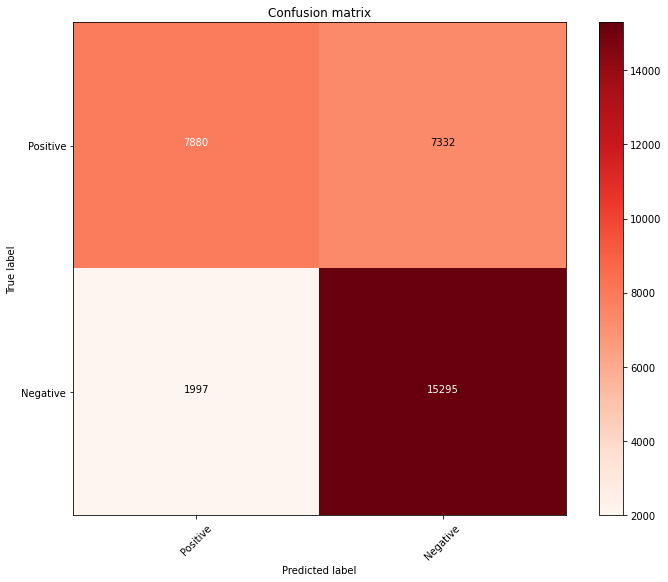

In [56]:
matrix = confusion_matrix(test_target,prediction)
matrix = np.flip(matrix)
#matrix = pd.DataFrame(matrix, columns=['Positive', 'Negative'], index =['Positive', 'Negative'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure(figsize=(10, 8))
plot_confusion_matrix(matrix, classes=['Positive', 'Negative'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

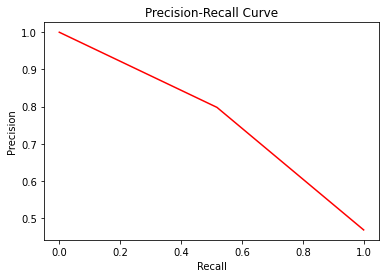

In [57]:
precision, recall, thresholds = precision_recall_curve(test_target,prediction)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='red')

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show() 

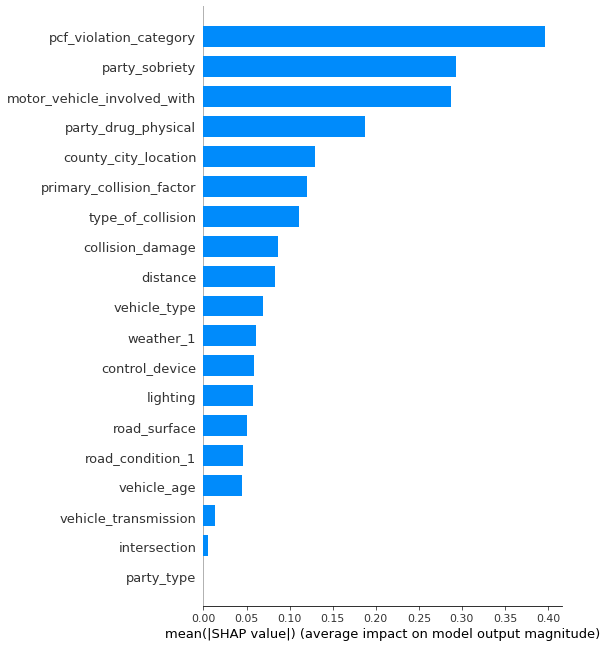

In [58]:
explainer = shap.TreeExplainer(model_5)
shap_values = explainer.shap_values(test_features)
shap.summary_plot(shap_values, test_features, plot_type="bar")

Исходя из графика мы видим, что сильное влияние на итоговую модель имеет категория нарушения, трезвость и дополнительные участники ДТП

In [59]:
df_3 = df_dropped[['party_sobriety','at_fault','vehicle_age']]
df_3['percent'] = 0
summing = df_3.groupby(by=["party_sobriety"]).sum()
counting = df_3.groupby(by=["party_sobriety"]).count()
for i in range(1,7):
    percent = (summing['at_fault'][i]/counting['at_fault'][i])*100
    summing['percent'][i] = percent

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Not stated'),
  Text(1, 0, 'had been drinking, impairment unknown'),
  Text(2, 0, 'had been drinking, not under influence'),
  Text(3, 0, 'had been drinking, under influence'),
  Text(4, 0, 'had not been drinking'),
  Text(5, 0, 'impairment unknown'),
  Text(6, 0, 'not applicable')])

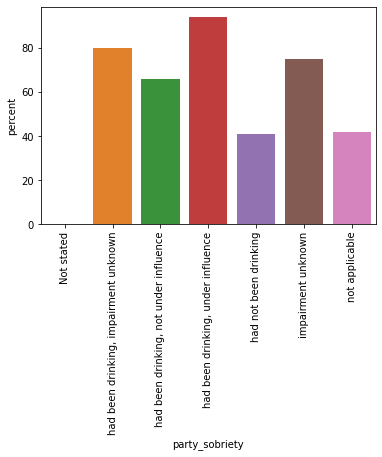

In [60]:
sns.barplot(data=summing,x=summing.index,y='percent')
plt.xticks(rotation = 90)

Исходя из графика можем сделать вывод, что наибольшее трезвость водителя имеет важное влияние и выпившие водители намного чаще являются виновниками аварии чем не выпившие

In [61]:
df_3 = df_dropped[['motor_vehicle_involved_with','at_fault','vehicle_age']]
df_3['percent'] = 0
summing = df_3.groupby(by=["motor_vehicle_involved_with"]).sum()
counting = df_3.groupby(by=["motor_vehicle_involved_with"]).count()
for i in range(1,5):
    percent = (summing['at_fault'][i]/counting['at_fault'][i])*100
    summing['percent'][i] = percent

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'animal'),
  Text(1, 0, 'bicycle'),
  Text(2, 0, 'fixed object'),
  Text(3, 0, 'motor vehicle on other roadway'),
  Text(4, 0, 'non-collision'),
  Text(5, 0, 'other motor vehicle'),
  Text(6, 0, 'other object'),
  Text(7, 0, 'parked motor vehicle'),
  Text(8, 0, 'train')])

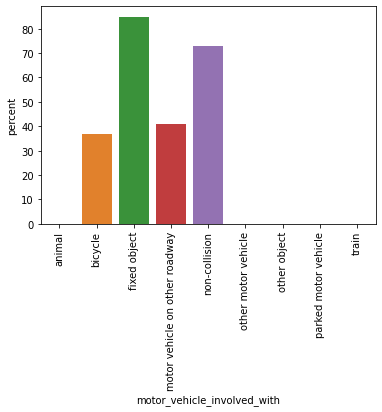

In [62]:
sns.barplot(data=summing,x=summing.index,y='percent')
plt.xticks(rotation = 90)

Исходя из графика можем сделать вывод, что если в ДТП были вовлечены: неподвижный объект или это было не столкновение, то скорее всего это произошло по вине водителя

In [63]:
df_3 = df_dropped[['pcf_violation_category','at_fault','vehicle_age']]
df_3['percent'] = 0
summing = df_3.groupby(by=["pcf_violation_category"]).sum()
counting = df_3.groupby(by=["pcf_violation_category"]).count()
for i in range(1,5):
    percent = (summing['at_fault'][i]/counting['at_fault'][i])*100
    summing['percent'][i] = percent

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'automobile right of way'),
  Text(1, 0, 'brakes'),
  Text(2, 0, 'dui'),
  Text(3, 0, 'fell asleep'),
  Text(4, 0, 'following too closely'),
  Text(5, 0, 'hazardous parking'),
  Text(6, 0, 'impeding traffic'),
  Text(7, 0, 'improper passing'),
  Text(8, 0, 'improper turning'),
  Text(9, 0, 'lights'),
  Text(10, 0, 'other equipment'),
  Text(11, 0, 'other hazardous violation'),
  Text(12, 0, 'other improper driving'),
  Text(13, 0, 'other than driver (or pedestrian)'),
  Text(14, 0, 'pedestrian right of way'),
  Text(15, 0, 'pedestrian violation'),
  Text(16, 0, 'speeding'),
  Text(17, 0, 'traffic signals and signs'),
  Text(18, 0, 'unknown'),
  Text(19, 0, 'unsafe lane change'),
  Text(20, 0, 'unsafe starting or backing'),
  Text(21, 0, 'wrong side of road')])

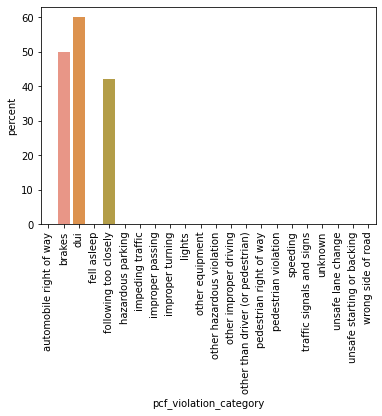

In [64]:
sns.barplot(data=summing,x=summing.index,y='percent')
plt.xticks(rotation = 90)

Исходя из графика можем сделать вывод, что если нарушение связано с трезвостью, тормозами или опасным сближением, то есть вероятность того что виновником ДТП был водитель, в остальных ДТП, исходя из наших данных, он не был виновен

## Выводы

Все модели при обучении показали хорошие результаты, чуть лучше себя показала модель бустинга. (F-score = 0.623), хуже всего себя показала модель леса (0.568). Исходя из результатов, на данный момент нельзя точно прогнозировать аварии